In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.isotonic import IsotonicRegression
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.autograd import Variable
from collections import OrderedDict
import tensorflow as tf

2023-01-27 14:52:10.738615: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv("../../data/SynthCross_n1000_p2.csv")
df["z"] = df["z"].apply(lambda x: 1 if x=="A" else 0)

In [3]:
class MyDataset(torch.utils.data.Dataset):
 
    def __init__(self, x_train, y_train, credal):
        x=x_train.values
        y=y_train.values
        self.X_train=torch.tensor(x,dtype=torch.float32)
        if not credal:
            self.Y_train=y.astype("float32")
        else:
            self.Y_train=y

    def __len__(self):
        return len(self.Y_train)
   
    def __getitem__(self,idx):
        return self.X_train[idx],self.Y_train[idx]

In [4]:
def KLD_loss_intervals(y_true, y_pred):    
    y_true_inf = y_true[:, 0].reshape(-1, 1)
    y_true_sup = y_true[:, 1].reshape(-1, 1)
    used_probas = torch.zeros(y_true.shape[0], 1)
    used_probas[y_pred <= y_true_inf] = y_true_inf[y_pred <= y_true_inf]
    used_probas[y_pred >= y_true_sup] = y_true_sup[y_pred >= y_true_sup]
    used_probas[(y_pred >= y_true_inf) & (y_pred <= y_true_sup)
                ] = y_pred[(y_pred >= y_true_inf) & (y_pred <= y_true_sup)]
    loss = torch.mean(used_probas* torch.log(used_probas/y_pred) + (1-used_probas)*torch.log((1-used_probas)/(1-y_pred)))
    return loss

In [5]:
def venn_abers_pytorch(trained_classifier, calibration_features, test_instance, calibration_labels):
    calibrations = trained_classifier.predict_probas(calibration_features, as_numpy=True, from_numpy=False)
    predictions = trained_classifier.predict_probas(test_instance, as_numpy=True, from_numpy=False)
    interval = []
    scores = pd.DataFrame()
    scores["s"] = calibrations[:, 0]
    scores["y"] = calibration_labels.to_numpy()
    score = pd.DataFrame()
    score["s"] = predictions[:, 0]
    interval = [] 
    for i in [0, 1]:
        score["y"] = i
        train = pd.concat([scores, score], ignore_index=True)
        g = IsotonicRegression()
        g.fit(train["s"], train["y"])
        interval.append(np.round(g.predict(score["s"])[0], 3))
    interval = np.array(interval)
    return interval

In [6]:
def plot_decision_boundary(dataset, labels, model, steps=1000, color_map='Paired'):
    color_map = plt.get_cmap(color_map)
    # Define region of interest by data limits
    print()
    xmin, xmax = dataset.to_numpy()[:, 0].min() - 1, dataset.to_numpy()[:, 0].max() + 1
    ymin, ymax = dataset.to_numpy()[:, 1].min() - 1, dataset.to_numpy()[:, 1].max() + 1
    steps = 1000
    x_span = np.linspace(xmin, xmax, steps)
    y_span = np.linspace(ymin, ymax, steps)
    xx, yy = np.meshgrid(x_span, y_span)

    # Make predictions across region of interest
    model.eval()
    labels_predicted = model(Variable(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()))

    # Plot decision boundary in region of interest
    labels_predicted = [0 if value <= 0.5 else 1 for value in labels_predicted.detach().numpy()]
    z = np.array(labels_predicted).reshape(xx.shape)
    
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.contourf(xx, yy, z, cmap=color_map, alpha=0.2)
    
    return fig, ax

In [7]:
class Simple_Neural_Net(nn.Module):
    def __init__(self, clipping_value):
        super().__init__()
        self.input_layer = nn.Sequential(OrderedDict({
            'linear': nn.Linear(in_features=2, out_features=3),
            'relu': nn.ReLU(inplace=True),
        }))
        self.hidden_layer = nn.Linear(in_features=3, out_features=1)
        self.output_layer = nn.Sigmoid()
        self.losses = {}
        self.accuracies = {}
        self.clipping_value = clipping_value
    
    def forward(self, x):
        y = self.input_layer(x)
        y = self.hidden_layer(y)
        y_pred = self.output_layer(y)
        return y_pred
    
    def __initiate_loss_and_accuracy_dicts(self, n_epochs):
        for i in range(n_epochs):
            self.losses[i] = 0
            self.accuracies[i] = 0
            
    def fit(self, x_train, y_train, epochs, learning_rate, verbose=True, credal=False):
        self.__initiate_loss_and_accuracy_dicts(n_epochs=epochs)
        myDs=MyDataset(x_train=x_train, y_train=y_train, credal=credal)
        train_loader=torch.utils.data.DataLoader(myDs,batch_size=10,shuffle=False)
        optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate)
        for e in range(epochs):
            n_batches = len(train_loader)
            if verbose:
                print(f'Epoch {e+1}/{epochs}')
                pbar = tf.keras.utils.Progbar(target=n_batches)
            for idx, batch in enumerate(train_loader):
                x, y = batch
                optimizer.zero_grad()
                outputs = self(x)
                
                outputs = torch.where(outputs>0.999, outputs-0.001, outputs)
                outputs = torch.where(outputs<0.001, outputs+0.001, outputs)
                if torch.any(outputs.isnan()):
                    print("JE SUIS LA")
                    import pdb; pdb.set_trace()
                if not credal:
                    loss = nn.BCELoss()
                    loss_value = loss(outputs, y.reshape(-1, 1))
                else:
                    loss_value = KLD_loss_intervals(y, outputs)
                    if torch.any(loss_value.isnan()):
                        print("IM HERE")
                        import pdb; pdb.set_trace()
                        torch.nn.utils.clip_grad_norm_(self.parameters(), self.clipping_value)
                loss_value.backward()
                optimizer.step()
                if not credal:
                    accuracy = accuracy_score(
                        y_true=y,
                        y_pred=outputs.reshape(-1).detach().numpy().round()
                    )
                    self.accuracies[e] += accuracy
                self.losses[e] += loss_value.detach().numpy()
                if verbose and not credal:
                    pbar.update(
                        idx,
                        values=[
                            ("loss", loss_value.detach().numpy()),
                            ("accuracy", accuracy)
                        ]
                    )
                elif verbose and credal:
                    pbar.update(
                        idx,
                        values=[
                            ("loss", loss_value.detach().numpy()),
                        ]
                    )
            self.losses[e] = self.losses[e]/n_batches
            self.accuracies[e] = self.accuracies[e]/n_batches
            if verbose:
                pbar.update(n_batches, values=None) 
            
    def predict_probas(self, x, as_numpy=False, from_numpy=True):
        if from_numpy:
            x = torch.tensor(x,dtype=torch.float32)
        outputs = self(x)
        if as_numpy:
            outputs = outputs.detach().numpy()
        return outputs

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(df[["X1", "X2"]], df["z"], train_size=0.8)
X_train, X_calib, Y_train, Y_calib = train_test_split(X_train, Y_train, train_size=0.975)
trainset = pd.DataFrame(X_train, columns=["X1", "X2"])
trainset["z"] = Y_train
trainset.iloc[80:, trainset.columns.get_loc("z")] = np.NaN 
known_train = trainset.iloc[0:80]
unknow_train = trainset.iloc[80:]
known_train.shape, unknow_train.shape, X_calib.shape, X_test.shape

((80, 3), (700, 3), (20, 2), (200, 2))

In [9]:
class SelfLearningUsingVennAbers():
    def __init__(
        self,
        known_x_train,
        known_y_train,
        unknown_x_train,
        calib_x_train, 
        calib_y_train,
        model_convergence_epochs
    ):
        self.model_convergence_epochs = model_convergence_epochs
        self.model = Simple_Neural_Net(clipping_value=0.1)
        self.known_x_train = known_x_train
        self.known_y_train = known_y_train
        self.unknown_x_train = unknown_x_train
        self.calib_x_train = calib_x_train
        self.calib_y_train = calib_y_train
        
        self.model.fit(self.known_x_train, self.known_y_train, epochs=self.model_convergence_epochs, learning_rate=0.2)
        self.accuracies = []
        fig, ax = plot_decision_boundary(dataset=df[["X1", "X2"]], labels=np.array([0, 1]), model=self.model)
        sns.scatterplot(data=df, x="X1", y="X2", hue="z", ax=ax)
        plt.show()
    
    def learning(self, validation_x, validation_y, n_epochs=10):
        self.known_y_train = self.known_y_train.apply(
            lambda x: np.stack([x+0.001, x+0.001] if x == 0 else [x-0.001, x-0.001], axis=-1).astype(np.float32))
        for epochs in range(n_epochs):
            self.unknown_x_train["interval"] =  self.unknown_x_train.apply(
                lambda x: venn_abers_pytorch(
                    self.model,
                    torch.from_numpy(self.calib_x_train[["X1", "X2"]].values.astype(np.float32)),
                    torch.from_numpy(x[["X1", "X2"]].values.reshape(1, -1).astype(np.float32)),
                    self.calib_y_train)
                ,
                axis=1
            )
            self.known_x_train = pd.concat(
                [
                    self.known_x_train,
                    self.unknown_x_train[["X1", "X2"]],
                ]
            )
            self.known_y_train = pd.concat(
                [
                    self.known_y_train,
                    self.unknown_x_train["interval"],
                ]
            )
            self.unknown_x_train = self.unknown_x_train[["X1", "X2"]]
            predictions = self.model.predict_probas(validation_x.to_numpy()).reshape(-1).detach().numpy().round()
            self.accuracies.append(accuracy_score(validation_y, predictions))
            if (epochs+1) % 5 == 0 or epochs==0:
                print(f"Accuracy epochs {epochs+1}: {accuracy_score(validation_y, predictions)}")
                fig, ax = plot_decision_boundary(dataset=df[["X1", "X2"]], labels=np.array([0, 1]), model=self.model)
                sns.scatterplot(data=df, x="X1", y="X2", hue="z", ax=ax)
                plt.show()
            if not epochs == n_epochs-1:
                self.model.fit(
                    self.known_x_train,
                    self.known_y_train,
                    epochs=self.model_convergence_epochs,
                    learning_rate=0.2,
                    verbose=False,
                    credal=True
                )
    def predict_probas(self, x_test):
        returns = x_test.copy()
        returns["interval"] = returns.apply(
                lambda x: venn_abers_pytorch(
                    self.model,
                    torch.from_numpy(self.calib_x_train[["X1", "X2"]].values.astype(np.float32)),
                    torch.from_numpy(x[["X1", "X2"]].values.reshape(1, -1).astype(np.float32)),
                    self.calib_y_train)
                ,
                axis=1
            )
        return returns

Epoch 1/10
8/8 [==============================] - 0s 4ms/step - loss: 0.6938 - accuracy: 0.5875
Epoch 2/10
8/8 [==============================] - 0s 5ms/step - loss: 0.6223 - accuracy: 0.7000
Epoch 3/10
8/8 [==============================] - 0s 8ms/step - loss: 0.5833 - accuracy: 0.7250
Epoch 4/10
8/8 [==============================] - 0s 3ms/step - loss: 0.5525 - accuracy: 0.7125
Epoch 5/10
8/8 [==============================] - 0s 2ms/step - loss: 0.5310 - accuracy: 0.7125
Epoch 6/10
8/8 [==============================] - 0s 3ms/step - loss: 0.5115 - accuracy: 0.7125
Epoch 7/10
8/8 [==============================] - 0s 5ms/step - loss: 0.4943 - accuracy: 0.6875
Epoch 8/10
8/8 [==============================] - 0s 3ms/step - loss: 0.4797 - accuracy: 0.6875
Epoch 9/10
8/8 [==============================] - 0s 3ms/step - loss: 0.4677 - accuracy: 0.6750
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.4575 - accuracy: 0.6875



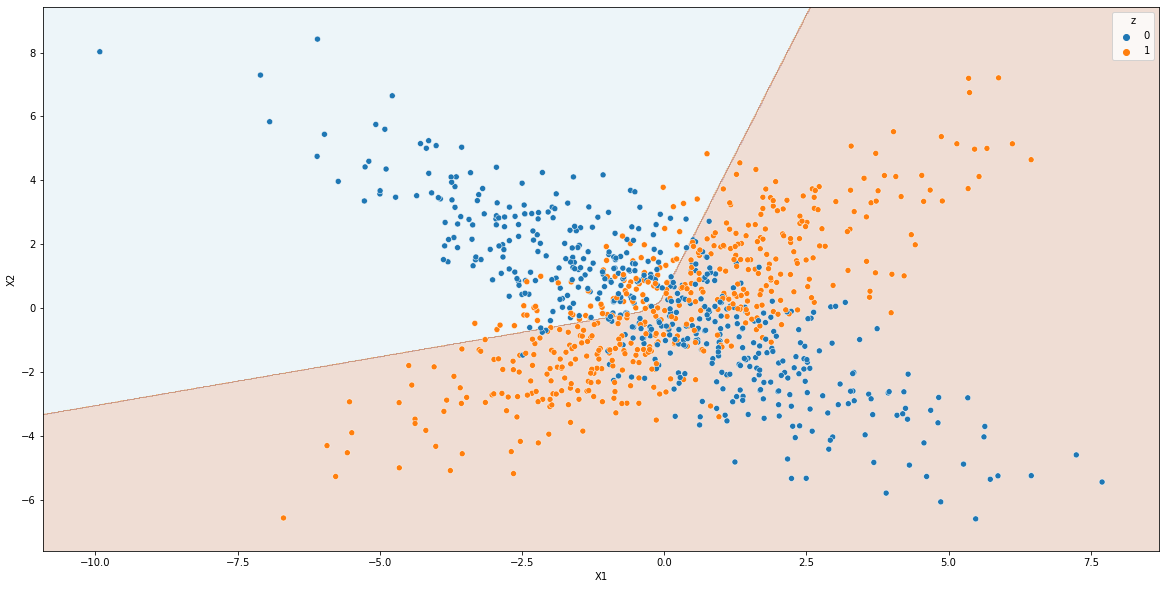

In [10]:
test = SelfLearningUsingVennAbers(
    known_x_train=known_train[["X1", "X2"]],
    known_y_train=known_train["z"],
    unknown_x_train=unknow_train[["X1", "X2"]],
    calib_x_train=X_calib[["X1", "X2"]],
    calib_y_train=Y_calib,
    model_convergence_epochs=10
)

Accuracy epochs 1: 0.635



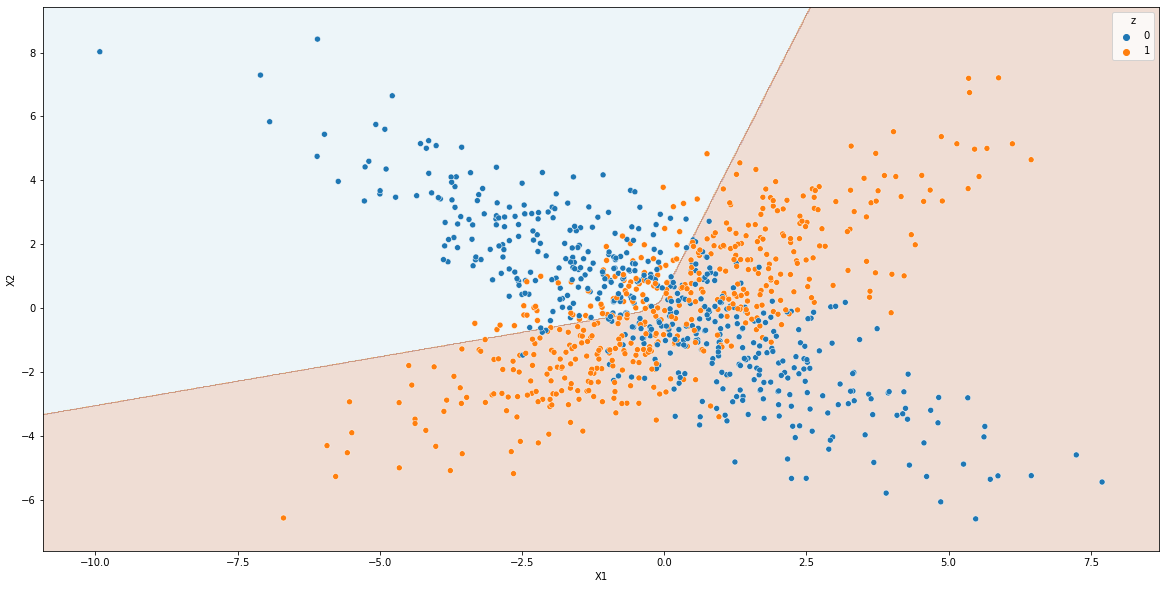

Accuracy epochs 5: 0.695



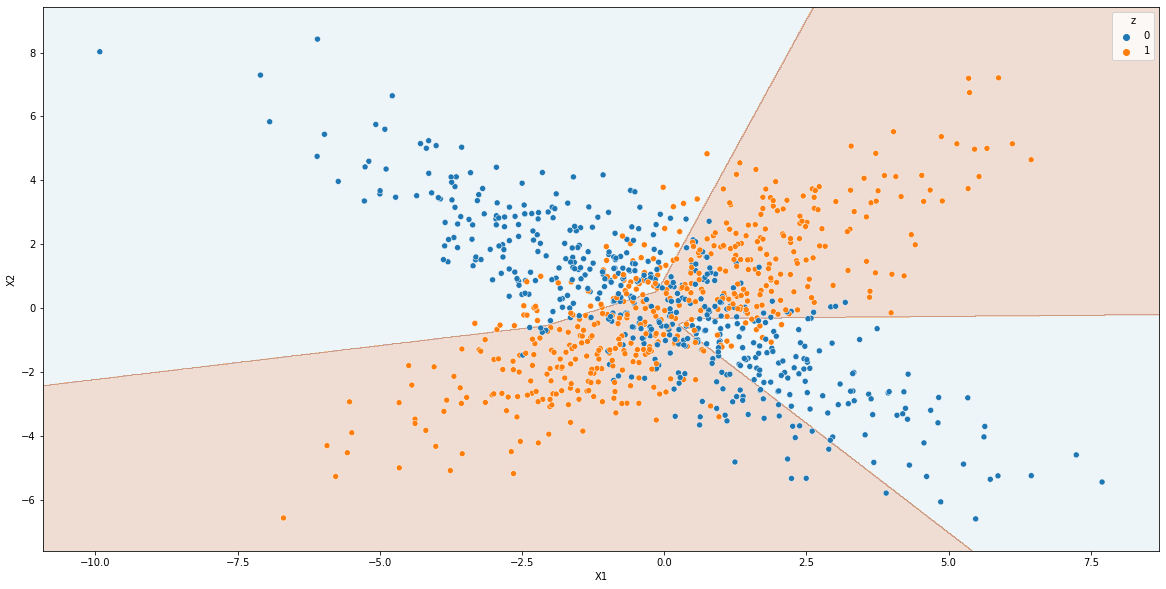

Accuracy epochs 10: 0.715



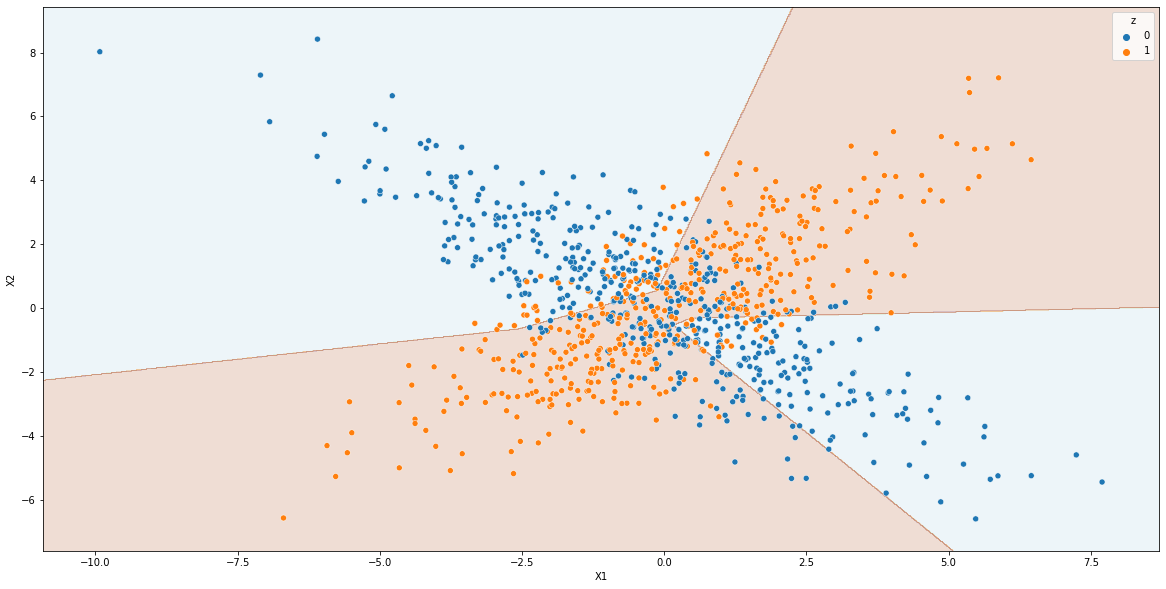

In [11]:
test.learning(validation_x=X_test, validation_y=Y_test, n_epochs=10)

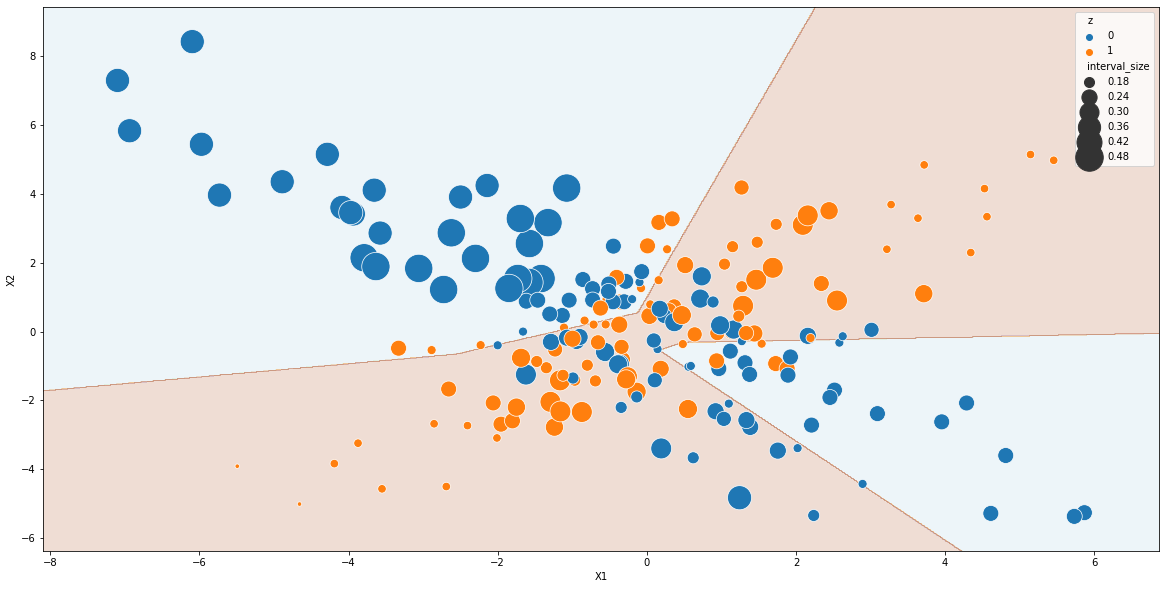

In [12]:
visu = test.predict_probas(X_test)
visu["interval_size"] = visu["interval"].apply(lambda x: x[1] - x[0])
fig, ax = plot_decision_boundary(dataset=X_test, labels=np.array([0, 1]), model=test.model)
sns.scatterplot(data=X_test, x="X1", y="X2", hue=Y_test, ax=ax, size=visu["interval_size"], sizes=(20, 800))
plt.show()

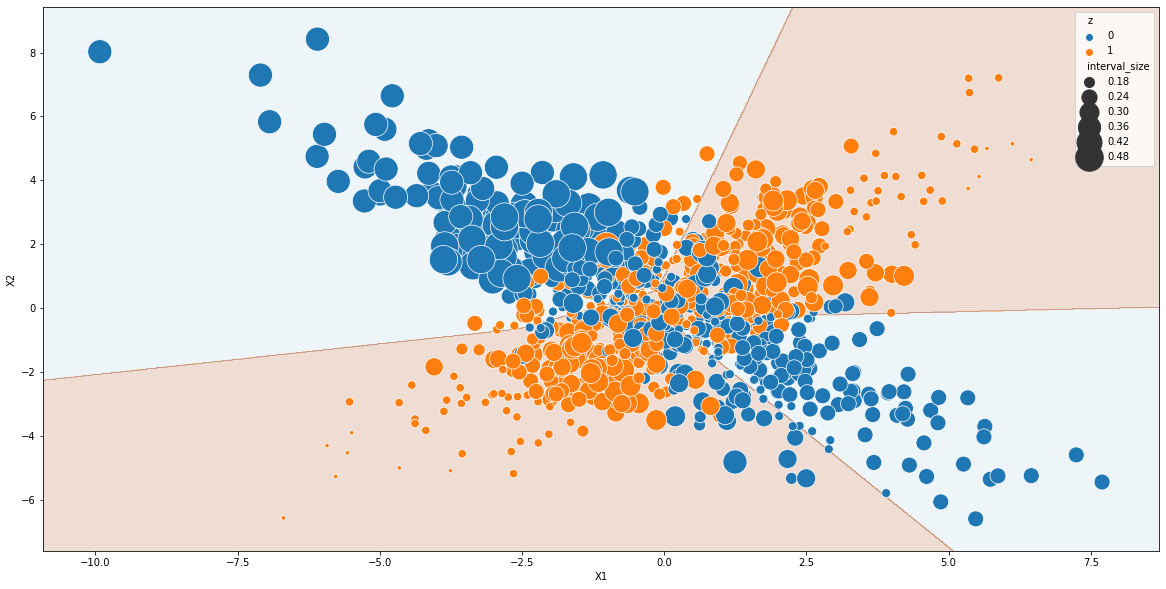

In [13]:
dff = pd.concat([df,pd.concat([X_calib, Y_calib], axis=1)]).drop_duplicates(keep=False)
new_df = test.predict_probas(x_test=dff[["X1", "X2"]])
new_df["interval_size"] = new_df["interval"].apply(lambda x: x[1] - x[0])
fig, ax = plot_decision_boundary(dataset=new_df, labels=np.array([0, 1]), model=test.model)
sns.scatterplot(data=new_df, x="X1", y="X2", hue=df["z"], ax=ax, size="interval_size", sizes=(20, 800))
plt.show()

In [14]:
visu["y"] = Y_test
visu["predicted"] = test.model.predict_probas(visu[["X1", "X2"]].to_numpy()).detach().numpy()
visu["label_predicted"] = test.model.predict_probas(visu[["X1", "X2"]].to_numpy()).detach().numpy().round()
visu.to_csv("observation_venn_abers.csv")

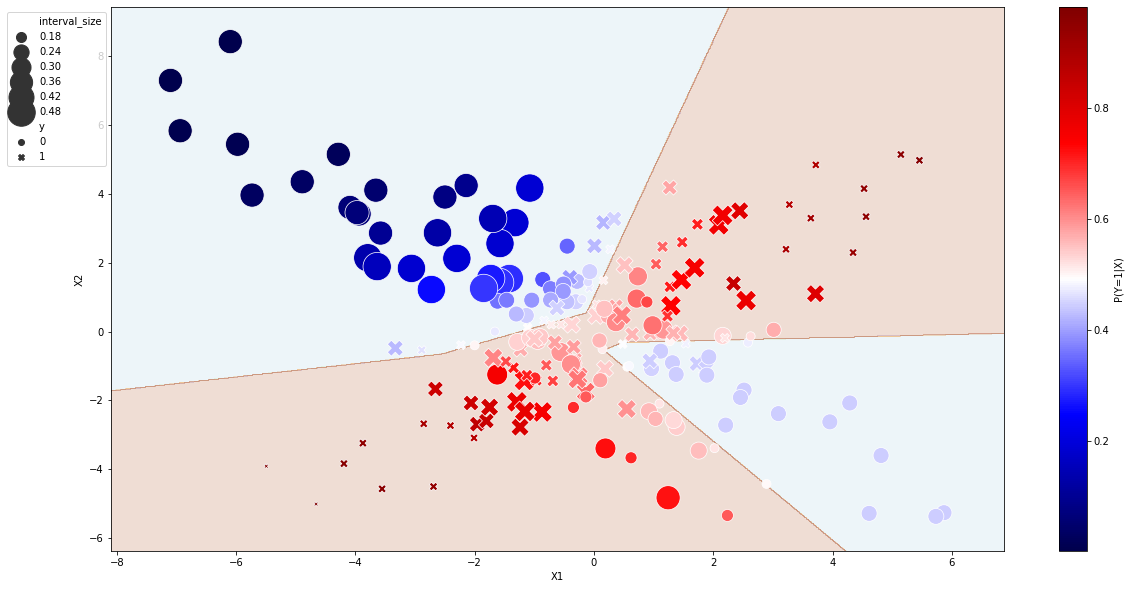

In [19]:
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
fig, ax = plot_decision_boundary(dataset=X_test, labels=np.array([0, 1]), model=test.model)
ax = sns.scatterplot(
    data=visu,
    x="X1",
    y="X2",
    c=visu["predicted"],
    ax=ax,
    size="interval_size",
    sizes=(20, 800),
    style="y",
    cmap = 'seismic'
)
norm = plt.Normalize(visu['predicted'].min(), visu['predicted'].max())
sm = plt.cm.ScalarMappable(cmap="seismic", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('P(Y=1|X)')
sns.move_legend(ax, "upper right", bbox_to_anchor=(0, 1))
plt.show()

In [16]:
new_df["predicted"] = test.model.predict_probas(new_df[["X1", "X2"]].to_numpy()).detach().numpy()
new_df["label_predicted"] = test.model.predict_probas(new_df[["X1", "X2"]].to_numpy()).detach().numpy().round()
new_df["y"] = dff["z"]

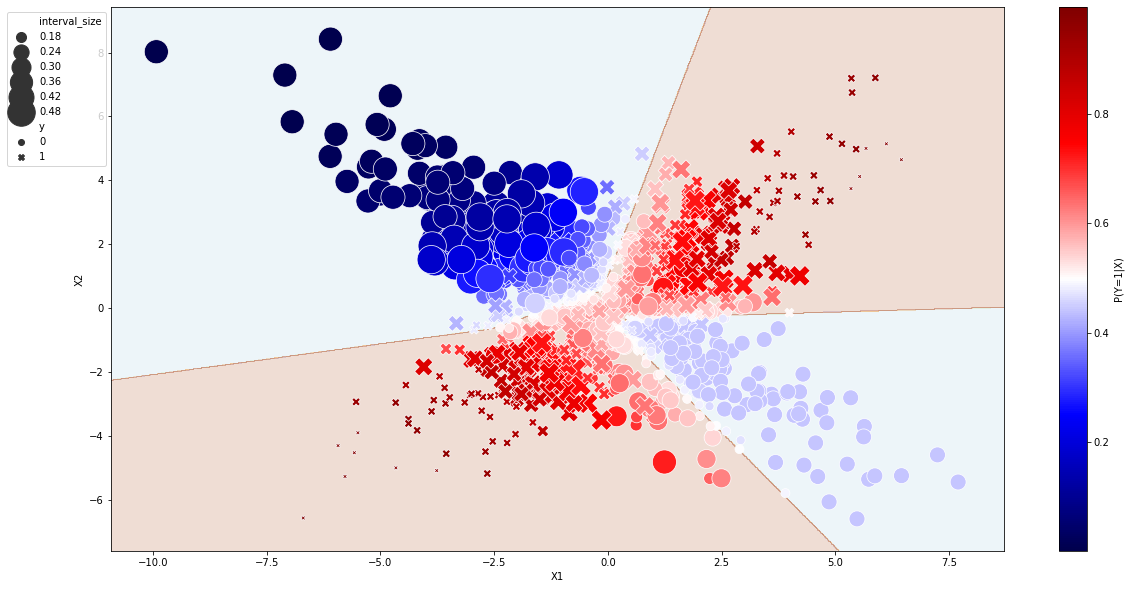

In [18]:
fig, ax = plot_decision_boundary(dataset=new_df, labels=np.array([0, 1]), model=test.model)
ax = sns.scatterplot(
    data=new_df,
    x="X1",
    y="X2",
    c=new_df["predicted"],
    ax=ax,
    size="interval_size",
    sizes=(20, 800),
    style="y",
    cmap = 'seismic'
)
norm = plt.Normalize(new_df['predicted'].min(), new_df['predicted'].max())
sm = plt.cm.ScalarMappable(cmap="seismic", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('P(Y=1|X)')
sns.move_legend(ax, "upper right", bbox_to_anchor=(0, 1))
plt.show()